## Hola soy un notebook de python de práctica

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as ppr
import seaborn as sns
import geopandas as gpd

In [43]:
%matplotlib inline

In [3]:
## Leemos los datos seleccionados
df_main = pd.read_csv('../data/TB_HOSP_VAC_FALLECIDOS.csv')
df_oxigen = pd.read_csv('../data/Oxigeno_25-10-2021.csv', sep="|")
df_camas = pd.read_csv('../data/Camas-08_03_2022.csv', sep="|")

In [4]:
# Validar integridad del identificador único
len(df_main['id_persona'].unique()), df_main.shape[0]

(135958, 136422)

In [5]:
df_main['id_persona'].isna().sum()

0

In [6]:
## conteo de cuantas veces se duplica los id_persona
filtro_duplicados = df_main['id_persona'].duplicated(keep=False)
df_main[filtro_duplicados]['id_persona'].value_counts().head()

26422634    3
6054506     3
29048330    3
3820273     2
9985143     2
Name: id_persona, dtype: int64

In [7]:
# TODO: Crear variable si fue reinfeccion (0, 1)
# TODO: Crear variable si con el # de la reinfeccion (1, 2, 3, etc)

In [8]:
## Número de valores perdidos
edad_na_count = df_main['edad'].isna().sum()
print(edad_na_count)
print(round(edad_na_count / df_main.shape[0] * 100, 2), '%')

7843
5.75 %


In [9]:
df_main['edad'].hist()
plt.show()

C:\Users\jose2\AppData\Local\Temp\ipykernel_7232\3643795002.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [10]:
df_main["edad"].describe()

count    128579.000000
mean         52.179446
std          20.436026
min           0.000000
25%          37.000000
50%          54.000000
75%          68.000000
max         111.000000
Name: edad, dtype: float64

In [11]:
counts, bins = np.histogram(df_main["edad"].dropna().values,bins = 7)
bins

array([  0.        ,  15.85714286,  31.71428571,  47.57142857,
        63.42857143,  79.28571429,  95.14285714, 111.        ])

In [12]:
edad_bins = pd.cut(df_main["edad"], bins = [0,5,13,18,25,40,55,65,80,95,112])

edad_bins_counts = edad_bins.value_counts()

edad_bins_counts


(40, 55]     29595
(65, 80]     26201
(25, 40]     25404
(55, 65]     23376
(80, 95]      9954
(18, 25]      7492
(5, 13]       2197
(13, 18]      1938
(0, 5]        1926
(95, 112]      451
Name: edad, dtype: int64

In [13]:
df_main["edad_bins"] = edad_bins

In [14]:
df_main["sexo"].isna().sum() / df_main.shape[0]

0.05013854070457844

In [15]:
df_main["sexo"].value_counts(), df_main["sexo"].value_counts(normalize= True)

(M    69149
 F    60433
 Name: sexo, dtype: int64,
 M    0.533631
 F    0.466369
 Name: sexo, dtype: float64)

In [16]:
conteo_edad_x_sexo = (df_main[["edad_bins","sexo"]].dropna() ## selecion de columns y elimino NaNs
                    .groupby(["edad_bins","sexo"]).size() )# agrupo y cuento las obs. por intervalo de edad y sexo

conteo_edad_x_sexo


edad_bins  sexo
(0, 5]     F         850
           M        1076
(5, 13]    F         927
           M        1270
(13, 18]   F        1310
           M         628
(18, 25]   F        5866
           M        1597
(25, 40]   F       15891
           M        9303
(40, 55]   F       11255
           M       18232
(55, 65]   F        8820
           M       14509
(65, 80]   F       10327
           M       15849
(80, 95]   F        4383
           M        5567
(95, 112]  F         242
           M         209
dtype: int64

In [17]:
## gráfica de barras de cantidad de personas por intervalo de edad por género

g = sns.catplot(
    data=conteo_edad_x_sexo.reset_index().rename(columns={0: "conteo"}),
     kind="bar",
    x="edad_bins", y="conteo", hue="sexo",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set_xticklabels(rotation = 90)

In [18]:
geo_vars = ['ubigeo_inei_domicilio', 'dep_domicilio', 'prov_domicilio',
       'dist_domicilio']
df_main[geo_vars].isna().sum()

ubigeo_inei_domicilio    0
dep_domicilio            0
prov_domicilio           0
dist_domicilio           0
dtype: int64

In [19]:
df_main['ubigeo_inei_domicilio'] = df_main['ubigeo_inei_domicilio'].astype(str)

In [20]:
df_main[geo_vars].dtypes

ubigeo_inei_domicilio    object
dep_domicilio            object
prov_domicilio           object
dist_domicilio           object
dtype: object

In [21]:
df_main[geo_vars].describe()

,ubigeo_inei_domicilio,dep_domicilio,prov_domicilio,dist_domicilio
count,136422,136422,136422,136422
unique,1716,25,196,1580
top,150142,LIMA,LIMA,VILLA EL SALVADOR
freq,7156,50719,46309,7156


**Manejando datos geoespaciales**

In [22]:
gdf_deps = gpd.read_file('../data/departamentos/DEPARTAMENTOS.shp')

In [23]:
## creando un plot del mapa
gdf_deps.plot()

<AxesSubplot:>

In [24]:
gdf_deps.columns

Index(['IDDPTO', 'DEPARTAMEN', 'CAPITAL', 'FUENTE', 'geometry'], dtype='object')

In [25]:
## analizando si tienen la misma llave mi base de datos y el del shapefile
df_unique_dep = df_main['dep_domicilio'].unique()
df_unique_dep.sort()

gdf_unique_dep = gdf_deps['DEPARTAMEN'].unique()
gdf_unique_dep.sort()

# VALIDAMOS QUE LOS NOMBRES DE DEPARTAMENTOS
# EN LOS DOS DATASETS SEAN IGUALES
(df_unique_dep == gdf_unique_dep).all() # True

True

In [26]:
# Contamos la cantidad de hospitalizados por departamento
conteo_x_dept = df_main['dep_domicilio'].value_counts()
conteo_x_dept = conteo_x_dept.reset_index()
conteo_x_dept.head()

,index,dep_domicilio
0,LIMA,50719
1,ANCASH,11753
2,CUSCO,10952
3,CAJAMARCA,8584
4,PIURA,7909


In [27]:
# Unimos los conteos utilizando los nombres de departamentos
gdf_conteo_x_dept = pd.merge(left=gdf_deps, right=conteo_x_dept, 
                             left_on="DEPARTAMEN", right_on='index')

In [28]:
gdf_conteo_x_dept.head()

,IDDPTO,DEPARTAMEN,CAPITAL,FUENTE,geometry,index,dep_domicilio
0,01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",AMAZONAS,1833
1,02,ANCASH,HUARAZ,INEI,"POLYGON ((-77.64692 -8.05086, -77.64669 -8.052...",ANCASH,11753
2,03,APURIMAC,ABANCAY,INEI,"POLYGON ((-73.74632 -13.17456, -73.74570 -13.1...",APURIMAC,2778
3,04,AREQUIPA,AREQUIPA,INEI,"POLYGON ((-71.98109 -14.64062, -71.98093 -14.6...",AREQUIPA,490
4,05,AYACUCHO,AYACUCHO,INEI,"POLYGON ((-74.34843 -12.17503, -74.35000 -12.1...",AYACUCHO,627


In [29]:
# Mapa de calor de # de hospitalizados x departamento
gdf_conteo_x_dept.plot("dep_domicilio", cmap='viridis',
                       legend=True)

<AxesSubplot:>

## Correlación

Es el valor numérico que describle la relación ( directa o inversa) entre dos variables, pero solo la forma **lineal**. Es decir, un correlación no indica que no existe relación entre las variables, sino que no presenta una relación lineal.

In [30]:
np.corrcoef(df_main["eess_renaes"],df_main["flag_uci"])

array([[1.        , 0.02111353],
       [0.02111353, 1.        ]])

In [31]:
df_main.corr()

,eess_renaes,id_eess,id_persona,edad,flag_uci,con_oxigeno,con_ventilacion,flag_vacuna,cdc_positividad,cdc_fallecido_covid
eess_renaes,1.000000,0.999724,0.019344,-0.115995,0.021114,-0.172506,0.049255,-0.008720,-0.189981,-0.078807
id_eess,0.999724,1.000000,0.020345,-0.115638,0.021211,-0.170655,0.050076,-0.009522,-0.189911,-0.077915
id_persona,0.019344,0.020345,1.000000,-0.115043,0.009564,-0.093752,0.003587,-0.465574,-0.126850,0.307252
edad,-0.115995,-0.115638,-0.115043,1.000000,0.031786,0.413115,0.023437,-0.126770,0.121101,0.418936
flag_uci,0.021114,0.021211,0.009564,0.031786,1.000000,0.166862,0.747212,-0.077172,0.042261,0.103393
con_oxigeno,-0.172506,-0.170655,-0.093752,0.413115,0.166862,1.000000,0.167074,-0.045013,0.193051,0.286102
con_ventilacion,0.049255,0.050076,0.003587,0.023437,0.747212,0.167074,1.000000,-0.083547,0.052755,0.136440
flag_vacuna,-0.008720,-0.009522,-0.465574,-0.126770,-0.077172,-0.045013,-0.083547,1.000000,0.095966,-0.658336
cdc_positividad,-0.189981,-0.189911,-0.126850,0.121101,0.042261,0.193051,0.052755,0.095966,1.000000,0.091382
cdc_fallecido_covid,-0.078807,-0.077915,0.307252,0.418936,0.103393,0.286102,0.136440,-0.658336,0.091382,1.000000


In [33]:
# Construir variable tiempo de hospitalizacion por covid
df_main['fecha_ingreso_hosp_dt'] = pd.to_datetime(df_main['fecha_ingreso_hosp'], format="%d/%m/%Y")
df_main['fecha_segumiento_hosp_ultimo_dt'] = pd.to_datetime(df_main['fecha_segumiento_hosp_ultimo'], format="%d/%m/%Y")

In [34]:
dias_hosp = df_main['fecha_segumiento_hosp_ultimo_dt'] - df_main['fecha_ingreso_hosp_dt']
dias_hosp.head()

0    9 days
1    8 days
2   38 days
3    7 days
4    4 days
dtype: timedelta64[ns]

In [38]:
# De segundos a dias
dias_hosp = dias_hosp.dt.total_seconds() / 60 / 60 / 24

In [39]:
df_main['dias_delta_hosp'] = dias_hosp

In [40]:
## correlación de días en el hospital con la edad
df_main['dias_delta_hosp'].corr(df_main['edad'])

0.13190281441847823

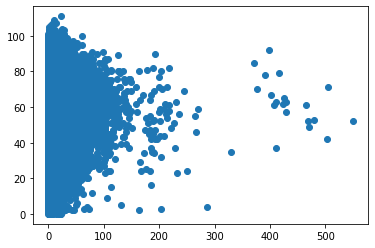

In [44]:
plt.scatter(x=df_main['dias_delta_hosp'], y=df_main['edad'])

In [45]:
corr_matrix_var = ['edad', 'flag_uci', 'cdc_positividad',
 'cdc_fallecido_covid', 'dias_delta_hosp']

In [46]:
corr_matrix  = df_main[corr_matrix_var].corr()
corr_matrix

,edad,flag_uci,cdc_positividad,cdc_fallecido_covid,dias_delta_hosp
edad,1.000000,0.031786,0.121101,0.418936,0.131903
flag_uci,0.031786,1.000000,0.042261,0.103393,0.316679
cdc_positividad,0.121101,0.042261,1.000000,0.091382,0.096393
cdc_fallecido_covid,0.418936,0.103393,0.091382,1.000000,-0.028707
dias_delta_hosp,0.131903,0.316679,0.096393,-0.028707,1.000000


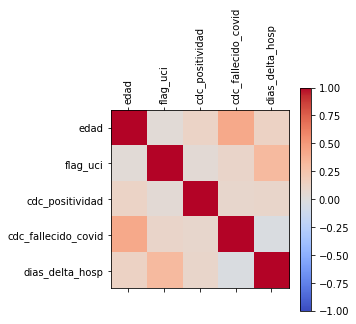

In [50]:
# Grafico de la matriz de correlacion

plt.rcParams['axes.grid'] = False  # Eliminar lineas dentro del grafico

plt.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Colocar nombres de variables en los ejes
plt.xticks(np.arange(corr_matrix.shape[0]), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(corr_matrix.shape[0]), corr_matrix.columns)

plt.colorbar() # Agregar un barra de colores como leyenda

plt.show()

#### Análisis exploratorio de datos

##### PREPARACIÓN ANTES DEL EDA

1. selecionar las variables a analizar que sean relevantes para el estudio
2. Verificar la integridad de las variables ( si estan limpias o que debemos hacer para limpiarlo)
3. plantearse preguntas de exploración ( posibles relaciones y que no son triviales,
ejm, % de personas que se contagiaron más de dos veces)
4. planterar hipotesis a partir de nnuestras variables ( se busca responder con test estadísticos)

##### EDA

5. limpiar los datos (80%)
6. Responder las preguntas de exploración a partir de los datos ( indicadores y gráficas)
7. responder las impotesis ( test estadísticos | estadisitica descriptiva)
8. Generar un reporte para el público en general.

In [52]:
profile = ppr.ProfileReport(df_main, title = "Pandas profiling report", minimal= True)

In [57]:
profile.to_file("../reports/tb_hosp_vac_fallecidos.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 66.73it/s]


### Preguntas de exploración

1. ¿Cúal es el índice de mortalidad por grupo de edad?
2.  ¿Cúal es el % de pacientes UCI vacunados con la 1,2 o 3 dosis?
3. ¿Cúal es la edad promedio de las personas que ingresaron a UCI?
4. ¿Cúal fue el tiempo promedio de recuperación de las personas que lograron salir de UCI?

In [60]:
## Índice de mortalidad por grupo de edad

## hopitalizados

df_main["fecha_ingreso_hosp_dt"].describe()

C:\Users\jose2\AppData\Local\Temp\ipykernel_7232\3692856276.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_main["fecha_ingreso_hosp_dt"].describe()


count                  136422
unique                    728
top       2021-04-09 00:00:00
freq                      452
first     2019-06-06 00:00:00
last      2022-03-08 00:00:00
Name: fecha_ingreso_hosp_dt, dtype: object

In [63]:
import datetime

In [65]:
df_main_filtrado = df_main[df_main["fecha_ingreso_hosp_dt"]> datetime.datetime(2020,3,6)]

In [68]:
# indice de mortalidad por grupo de edad
# muestra; personas hospitalizadas entre 2020-03-16 al 2022-03-08
# Formula; $ personas fallecidas entre x y y años / total de personas hospitalizadas

num_fallecidos_x_edad = df_main_filtrado.groupby(["cdc_fallecido_covid","edad_bins"]).size()
num_fallecidos_x_edad

cdc_fallecido_covid  edad_bins
0                    (0, 5]        1869
                     (5, 13]       2159
                     (13, 18]      1891
                     (18, 25]      7332
                     (25, 40]     23733
                     (40, 55]     23095
                     (55, 65]     14735
                     (65, 80]     12972
                     (80, 95]      4175
                     (95, 112]      148
1                    (0, 5]          57
                     (5, 13]         38
                     (13, 18]        47
                     (18, 25]       160
                     (25, 40]      1671
                     (40, 55]      6498
                     (55, 65]      8641
                     (65, 80]     13227
                     (80, 95]      5778
                     (95, 112]      303
dtype: int64

In [70]:
total_hosp = df_main_filtrado.groupby("edad_bins").size()
total_hosp

edad_bins
(0, 5]        1926
(5, 13]       2197
(13, 18]      1938
(18, 25]      7492
(25, 40]     25404
(40, 55]     29593
(55, 65]     23376
(65, 80]     26199
(80, 95]      9953
(95, 112]      451
dtype: int64

In [74]:
perc_fallecidos_edad = num_fallecidos_x_edad.copy()
perc_fallecidos_edad = (num_fallecidos_x_edad.loc[1] / total_hosp * 100)


In [75]:
perc_fallecidos_edad

edad_bins
(0, 5]        2.959502
(5, 13]       1.729631
(13, 18]      2.425181
(18, 25]      2.135611
(25, 40]      6.577704
(40, 55]     21.957895
(55, 65]     36.965264
(65, 80]     50.486660
(80, 95]     58.052848
(95, 112]    67.184035
dtype: float64

<AxesSubplot:xlabel='edad_bins'>

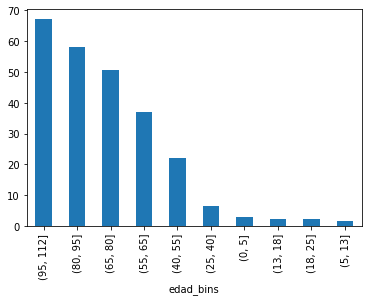

In [89]:
perc_fallecidos_edad.sort_values(ascending=False).plot(kind='bar')


In [90]:
# Pacientes UCI vacunados con la 1, 2 o 3 dosis

filtro_uci = df_main_filtrado['flag_uci'] == 1
df_main_filtrado_uci = df_main_filtrado[filtro_uci]

filtro_fechas_vacunacion = df_main_filtrado_uci['fecha_ingreso_hosp_dt'] >= datetime.datetime(2021, 2, 25)
df_main_filtrado_uci = df_main_filtrado_uci[filtro_fechas_vacunacion]

vars_vacuna = ['fecha_dosis1', 'fecha_dosis2', 'fecha_dosis3']

# Conteo de numero de dosis
df_main_filtrado_uci['n_dosis'] = df_main_filtrado_uci[vars_vacuna].notna().sum(axis=1)
# Conteo & porcentaje de pacientes UCI con 0, 1, 2 o 3 dosis 
df_main_filtrado_uci['n_dosis'].value_counts(), df_main_filtrado_uci['n_dosis'].value_counts(normalize=True) * 100

(0    4139
 2    3106
 3    2315
 1     654
 Name: n_dosis, dtype: int64,
 0    40.522812
 2    30.409242
 3    22.664970
 1     6.402976
 Name: n_dosis, dtype: float64)

In [91]:
# Edad promedio de las pacientes UCI
print('Edad promedio de las pacientes UCI:')
df_main_filtrado[filtro_uci]['edad'].mean().round(0)


Edad promedio de las pacientes UCI:


54.0

In [93]:
# Tiempo promedio de recuperación de pacientes UCI recuperados
# Muestra: Pacientes que entraron y se recuperaron
# Formula: SUM(Fecha de alta medica - Fecha de ingreso UCI para cada paciente) / # pacientes 

filtro_inicio_pandemia = df_main['fecha_ingreso_hosp_dt'] > datetime.datetime(2020, 3, 6)

df_main['fecha_ingreso_uci_dt'] = pd.to_datetime(df_main['fecha_ingreso_uci'], format='%d/%m/%Y')

filtro_alta_med = df_main['evolucion_hosp_ultimo'] == 'alta'
df_main_filtro_uci_recuperados = df_main[filtro_inicio_pandemia & filtro_uci & filtro_alta_med]

tiempo_recuperacion_uci = df_main_filtro_uci_recuperados['fecha_segumiento_hosp_ultimo_dt'] - df_main_filtro_uci_recuperados['fecha_ingreso_uci_dt']
print("Tiempo promedio de recuperación de pacientes UCI recuperados:")
tiempo_recuperacion_uci.mean()

Tiempo promedio de recuperación de pacientes UCI recuperados:


Timedelta('23 days 22:39:53.397524071')